## This notebook is used to explore how different features impacts the RF algorithm on predicting Prot. Data from https://arxiv.org/abs/1402.5694

In [213]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
   'figure.figsize': [10,10], # instead of 4.5, 4.5
   'savefig.format': 'eps',
   }
plt.rcParams.update(params)

Read in data

In [214]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.utils as au
from astropy.io import fits

# read in McQuillian stars
McQS = pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','Rper','LPH','w','DC','Flag'))
#print(McQS)

# gaia data from https://gaia-kepler.fun/
with fits.open('kepler_dr2_1arcsec.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")
#print(gaia)

# merge two tables with same KID
df = pd.merge(McQS, gaia, left_on="KID", right_on="kepid", how="inner")
#print(df)

# drop duplicates
df.drop_duplicates(subset ="KID", keep = False, inplace = True) 
#print(df)

# [1] Get Velocity

Code from Adrian Price-Whelan to calculate $v_{tan}=\sqrt{v_{ra}^2+v_{dec}^2}$ and $v_b$

In [215]:
import astropy.coordinates as coord
d = coord.Distance(parallax=np.array(df.parallax) * u.mas,allow_negative=True)
vra = (np.array(df.pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
vdec = (np.array(df.pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
# v_b as a proxy for v_z:
c = coord.SkyCoord(ra=np.array(df.ra)*u.deg, dec=np.array(df.dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(df.pmra)*u.mas/u.yr,
                  pm_dec=np.array(df.pmdec)*u.mas/u.yr)
gal = c.galactic
v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
# print(vb)

# add v_b and v_tan into dataframe
df['v_b']=v_b
df['v_tan']=v_t
df=df.dropna(subset=['v_b','v_tan'])
print(df)

            KID  Teff  logg_x    Mass    Prot  Prot_err      Rper    LPH  \
0        892376  3813    4.47  0.4699   1.532     0.007   7306.69  0.823   
1       1026146  4261    4.57  0.6472  14.891     0.120  11742.56  1.405   
2       1026474  4122    4.56  0.5914   1.569     0.006  30471.80  1.204   
3       1162635  3760    4.77  0.4497  15.678     0.019  10207.47  0.978   
4       1164102  4045    4.62  0.5606  31.496     0.474   5139.74  0.568   
...         ...   ...     ...     ...     ...       ...       ...    ...   
34885  12934451  5556    4.46  0.9798  17.244     0.567   2147.85  0.435   
34886  12934465  4714    4.88  0.7591  34.910     1.692   4572.33  0.433   
34887  12934525  5278    4.72  0.9062  25.101     0.240   5150.14  0.573   
34888  12934557  5341    4.58  0.9227  31.226     0.729   1889.88  0.401   
34889  12984138  4960    4.57  0.8239  12.059     0.038  11734.90  1.194   

            w  DC  ... nconfp  nkoi ntce    jmag    hmag    kmag  planet?  \
0      0.4

/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/units/equivalencies.py:90: RuntimeWarning: invalid value encountered in less
  d[d < 0] = np.nan
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/lucy/anaconda3/lib/pytho

# [1] Random Forest

In [246]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import normalize
# can ignore multiple features (already excluding Prot, M14, C16)
def my_randF_mask(df,traind,ignf_2=[]):
    # inputs
    # other features: R35, R1s? 
    # df: the data
    # traind: what fraction of data use to train
    # ignf_2: what features to ignor
    
    # outputs:
    # flib: lib for features indexed
    # regr: trained model
    # importance: importance of features
    # actrualF: actrual feature used
    # predictp: predicted periods
    
    # ignored features
    ignf=['Prot','Prot_err','M14','C16','source_id','solution_id','gaia_ref_epoch','random_index','ra_error','ntce','DC','matched_observations','kepid']+ignf_2
    print('ignored features',ignf)
    # number the features with dictionary
    fl=len(df.columns) # how many features
    keys=range(fl)
    flib=dict(zip(keys, df.columns))

    featl=len(df.Prot) # feature length

    actrualF=[] # actrual feature used
    # fill in feature array
    lenX=0
    featureind=[]
    for i in range(1,fl):
        feature=df.iloc[:,i]
        # if input not string, not Prot and no NaN
        if (type(feature[0]) is not str) and ('err' not in flib[i]) and (flib[i] not in ignf) and (not np.isnan(feature).any()):
            lenX=lenX+1
            featureind.append(i)
            
    X=np.zeros([featl,lenX])
    
    counter=0
    for i in featureind:
        X[:,counter]=df.iloc[:,i]
        actrualF.append(flib[i])
        counter=counter+1
    
    
    # output
    y=np.array(df.Prot)

    # run random forest
    regr = RandomForestRegressor(random_state=0,n_estimators=100)
    regr.fit(X[0:int(traind*featl),:], y[0:int(traind*featl)])  

    # get the importance of each feature
    importance=regr.feature_importances_
    
    # make prediction
    predictp=np.zeros([len(range(int(traind*featl)+1,featl)),1]) # predicted period
    difc=0
    for i in range(int(traind*featl)+1,featl):
        predictp[difc]=regr.predict([X[i,:]])
        difc=difc+1
    
    return flib,regr,importance,actrualF,predictp,X

In [250]:
# for plotting results for importance and predict vs true
def plot_result(actrualF,importance,prediction,Prot,Prot_err,traind,topn=20):
    # inputs:
    # actrualF: feature used in training (output from my_randF_mask)
    # importance/prediction: output from my_randF function
    # Prot: target period
    # Prot_err: target period error
    # traind: how many percentage of data is used to train
    # topn: how many features to plot (default=20)
    # X: features, if X is inputed then plot feature vs Prot
    
    # output: 
    # my_xticks: importance of features in decending order
    
    featl=len(Prot)
    # zip the importance with its feature name
    list1 = list(zip(actrualF,importance))
    # sort the zipped list
    decend=sorted(list1, key=lambda x:x[1])
    #print(decend)

    # how many features to plot 
    x=range(topn)
    # put Prot in y
    y=np.array(df.Prot)
    # data used to test prediction
    y_test=y[int(traind*featl)+1:featl]
    y_test_err=np.array(df.Prot_err)[int(traind*featl)+1:featl]
    # length
    featl=len(df.Prot) # feature length

    #print('ra_dec_corr : Correlation between right ascension and declination. Correlation coefficient ρ(α,δ)between right ascension and declination, a dimensionless quantity in the range [-1,+1]')
    #print('Rper: the average amplitude of variability within one period')
    #print('LPH: the height of the selected peak with respect to the mean of the troughs on either side')
    ####################  get most important features ############################################################
    # get index and value for y
    y_val=[decend[i][1] for i in range(len(decend)-topn,len(decend))]
    my_xticks=[decend[i][0] for i in range(len(decend)-topn,len(decend))]

    plt.figure(figsize=(20,5))
    plt.title('Most important features',fontsize=25)
    plt.xticks(x, my_xticks)
    plt.plot(x, y_val,'k-')
    plt.xlim([max(x),min(x)])
    plt.xticks(rotation=90)
    plt.ylabel('importance')
    ####################  get most important features ############################################################

    '''
    ####################  get least important features ############################################################
    # get index and value for y
    y_val=[decend[i][1] for i in range(topn)]
    my_xticks=[decend[i][0] for i in range(topn)]

    plt.figure(figsize=(20,5))
    plt.title('Least important features',fontsize=25)
    plt.xticks(x, my_xticks)
    plt.plot(x, y_val,'k-')
    plt.xlim([max(x),min(x)])
    plt.xticks(rotation=90)
    plt.ylabel('importance')
    ####################  get least important features ###########################################################
    '''
    # prediction vs true
    plt.figure(figsize=(10,8))
    plt.plot(prediction,prediction,'k--',label='y=x')
    plt.errorbar(prediction,y_test,yerr=y_test_err,fmt='r.',Markersize=3,alpha=0.2)
    plt.xlabel('Predicted Period')
    plt.ylabel('True Period')
    plt.ylim([0,max(predict)])
    plt.xlim([0,max(predict)])
    plt.legend()
    
    for i in range(len(y_test)):
        if y_test_err[i]==0:
            y_test[i]=0
            predict[i]=0
            y_test_err[i]=1
    avstedv=sum([(y_test[i]-prediction[i])**2./y_test_err[i] for i in range(len(y_test_err))])/len(predict)
    print('average chisq is: ',avstedv)
    return(my_xticks)
    
def plot_corr(df,my_xticks):
    topn=len(my_xticks)
    plt.figure(figsize=(int(topn*2.5),int(topn*2.5)))
    # get subplot config
    com_mul=[] 
    # get all multiplier
    for i in range(1,topn):
        if float(topn)/float(i)-int(float(topn)/float(i))==0:
            com_mul.append(i)
        
    # total rows and columns
    col=int(np.median(com_mul))
    row=int(topn/col)
        
    # plot feature vs Prot
    for i in range(topn):
        plt.subplot(row,col,topn-i)
        featurep=df[my_xticks[i]]
        plt.plot(df.Prot,featurep,'k.',markersize=1)
        plt.title(my_xticks[i],fontsize=25)
        stddata=np.std(featurep)
        plt.ylim([np.median(featurep)-3*stddata,np.median(featurep)+3*stddata])
        plt.xlabel('Prot')
        plt.ylabel(my_xticks[i])


# [3] For results including w

In [248]:
traind=0.7
flib,regr,importance,actrualF,predict,X=my_randF_mask(df,traind)
# get a score for cross-validation
#scores = cross_val_score(regr, X[int(traind*featl)+1:featl,:], np.array(df.Prot)[int(traind*featl)+1:featl], cv=10, scoring='neg_mean_absolute_error')

['Prot', 'Prot_err', 'M14', 'C16', 'source_id', 'solution_id', 'gaia_ref_epoch', 'random_index', 'ra_error', 'ntce', 'DC', 'matched_observations', 'kepid']


average chisq is:  [1112.20166318]


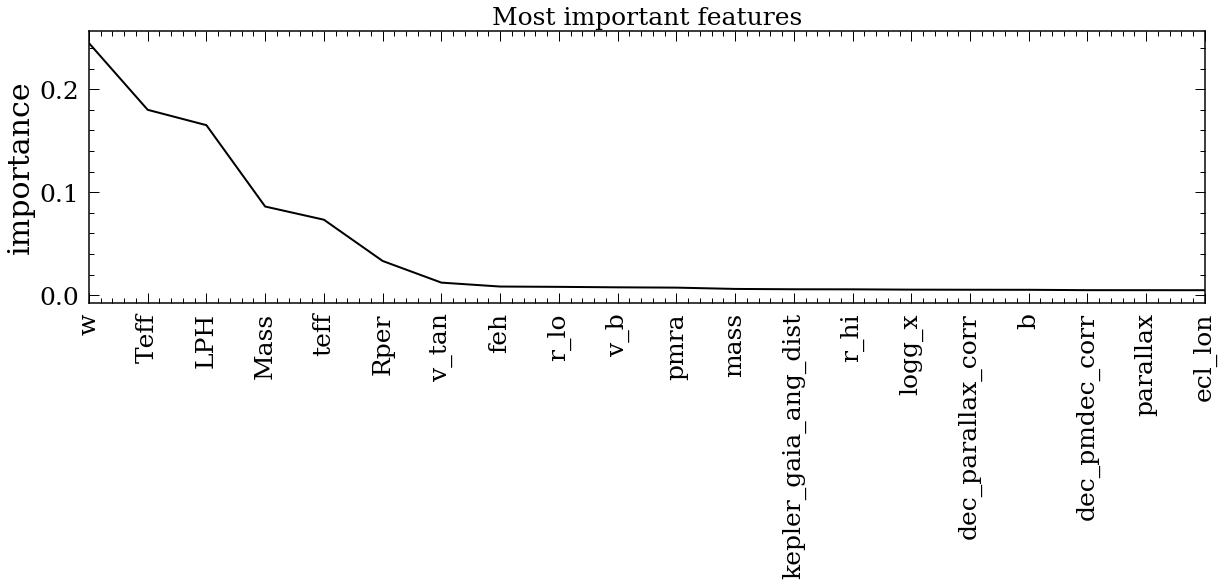

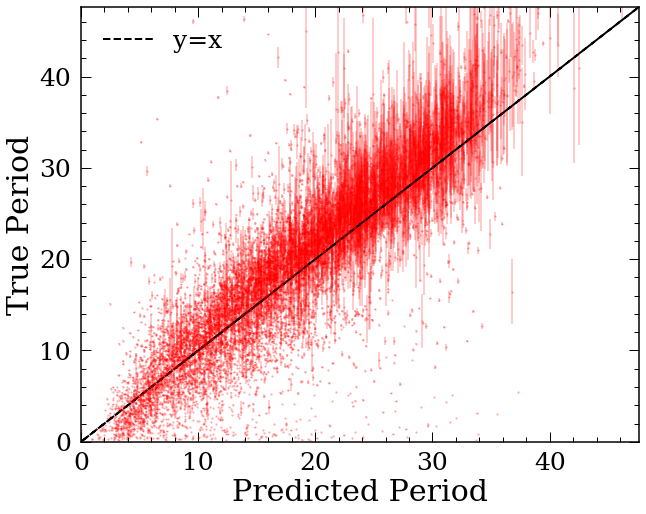

In [251]:
x_ticks=plot_result(actrualF,importance,predict,df.Prot,df.Prot_err,traind)  

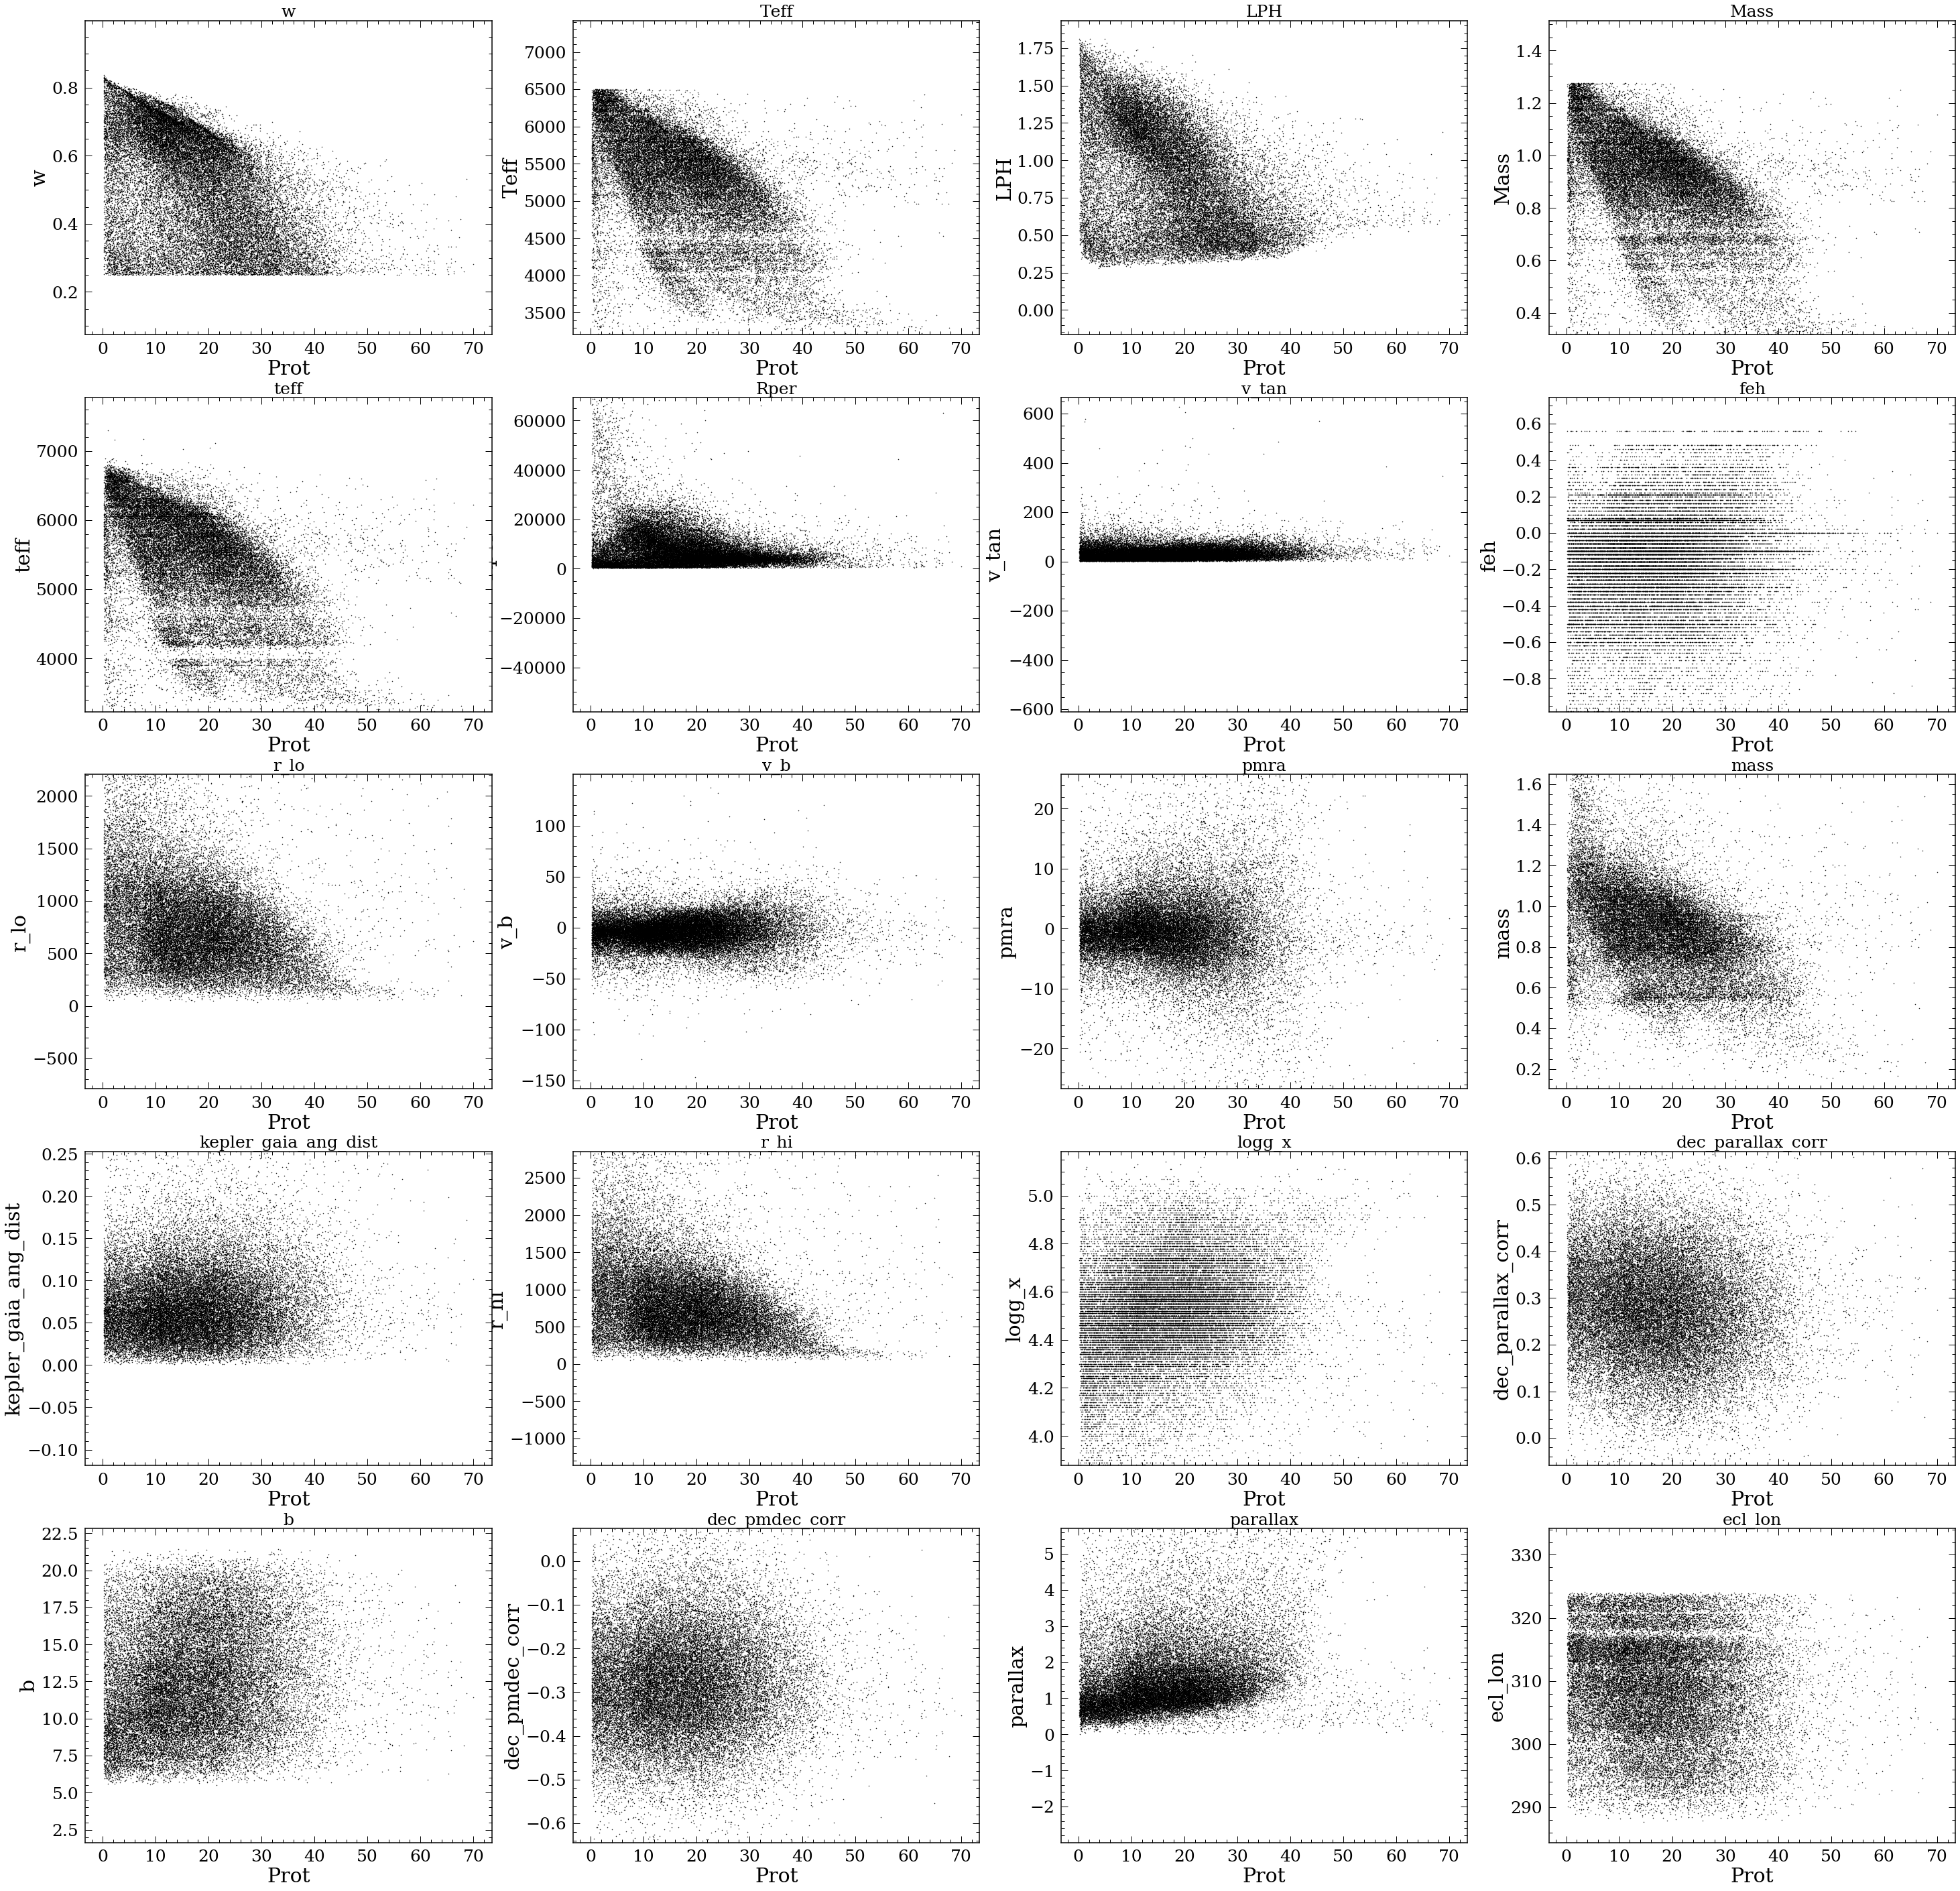

In [252]:
plot_corr(df,x_ticks)

# [4] For results excluding w and LPH since we probably can't get from TESS

In [253]:
# for getting rid of weight and LHP
ignf_2=['w','LPH']
flib_w,regr_w,importance_w,actrualF_w,predict_w,X_w=my_randF_mask(df,traind,ignf_2)

['Prot', 'Prot_err', 'M14', 'C16', 'source_id', 'solution_id', 'gaia_ref_epoch', 'random_index', 'ra_error', 'ntce', 'DC', 'matched_observations', 'kepid', 'w', 'LPH']


average chisq is:  [1630.80685871]


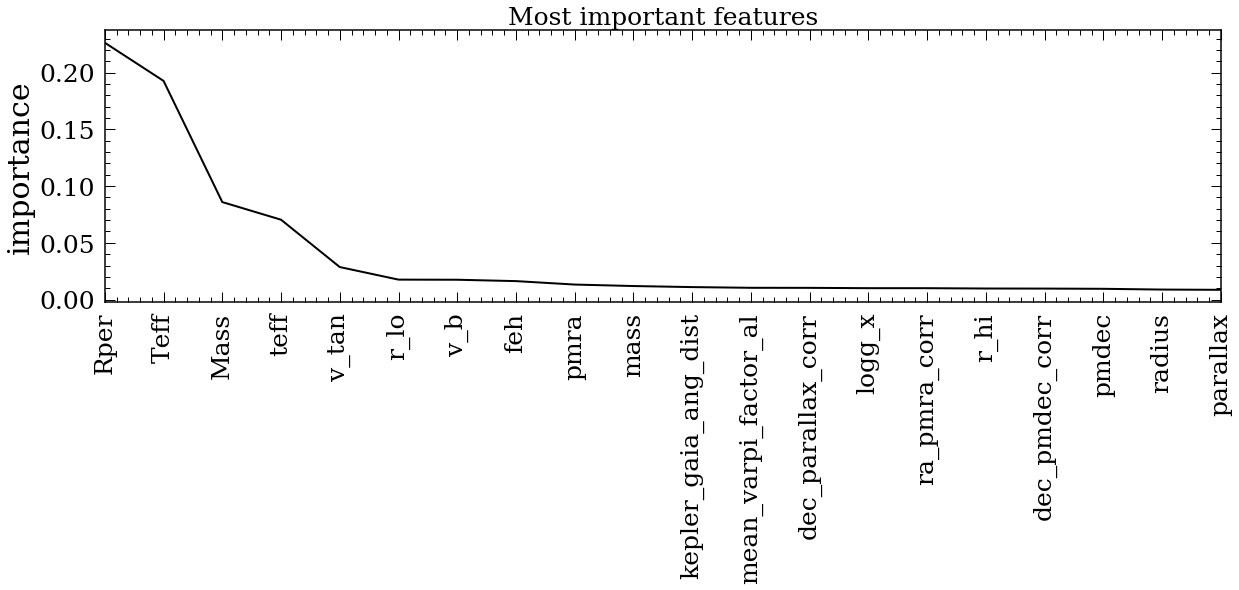

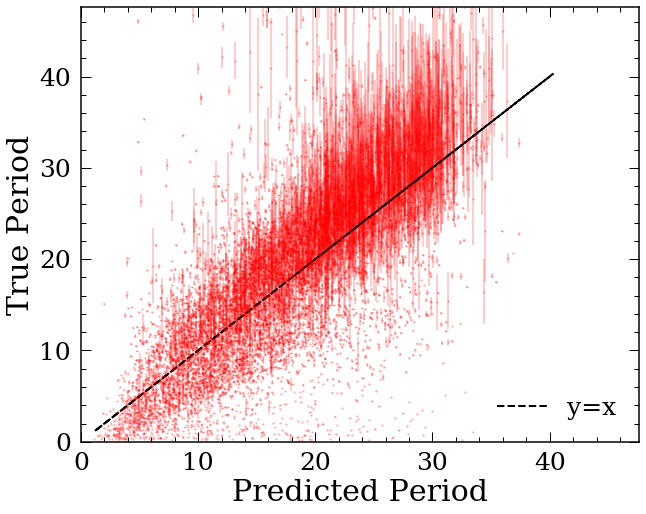

In [254]:
x_ticks_w=plot_result(actrualF_w,importance_w,predict_w,df.Prot,df.Prot_err,traind)  

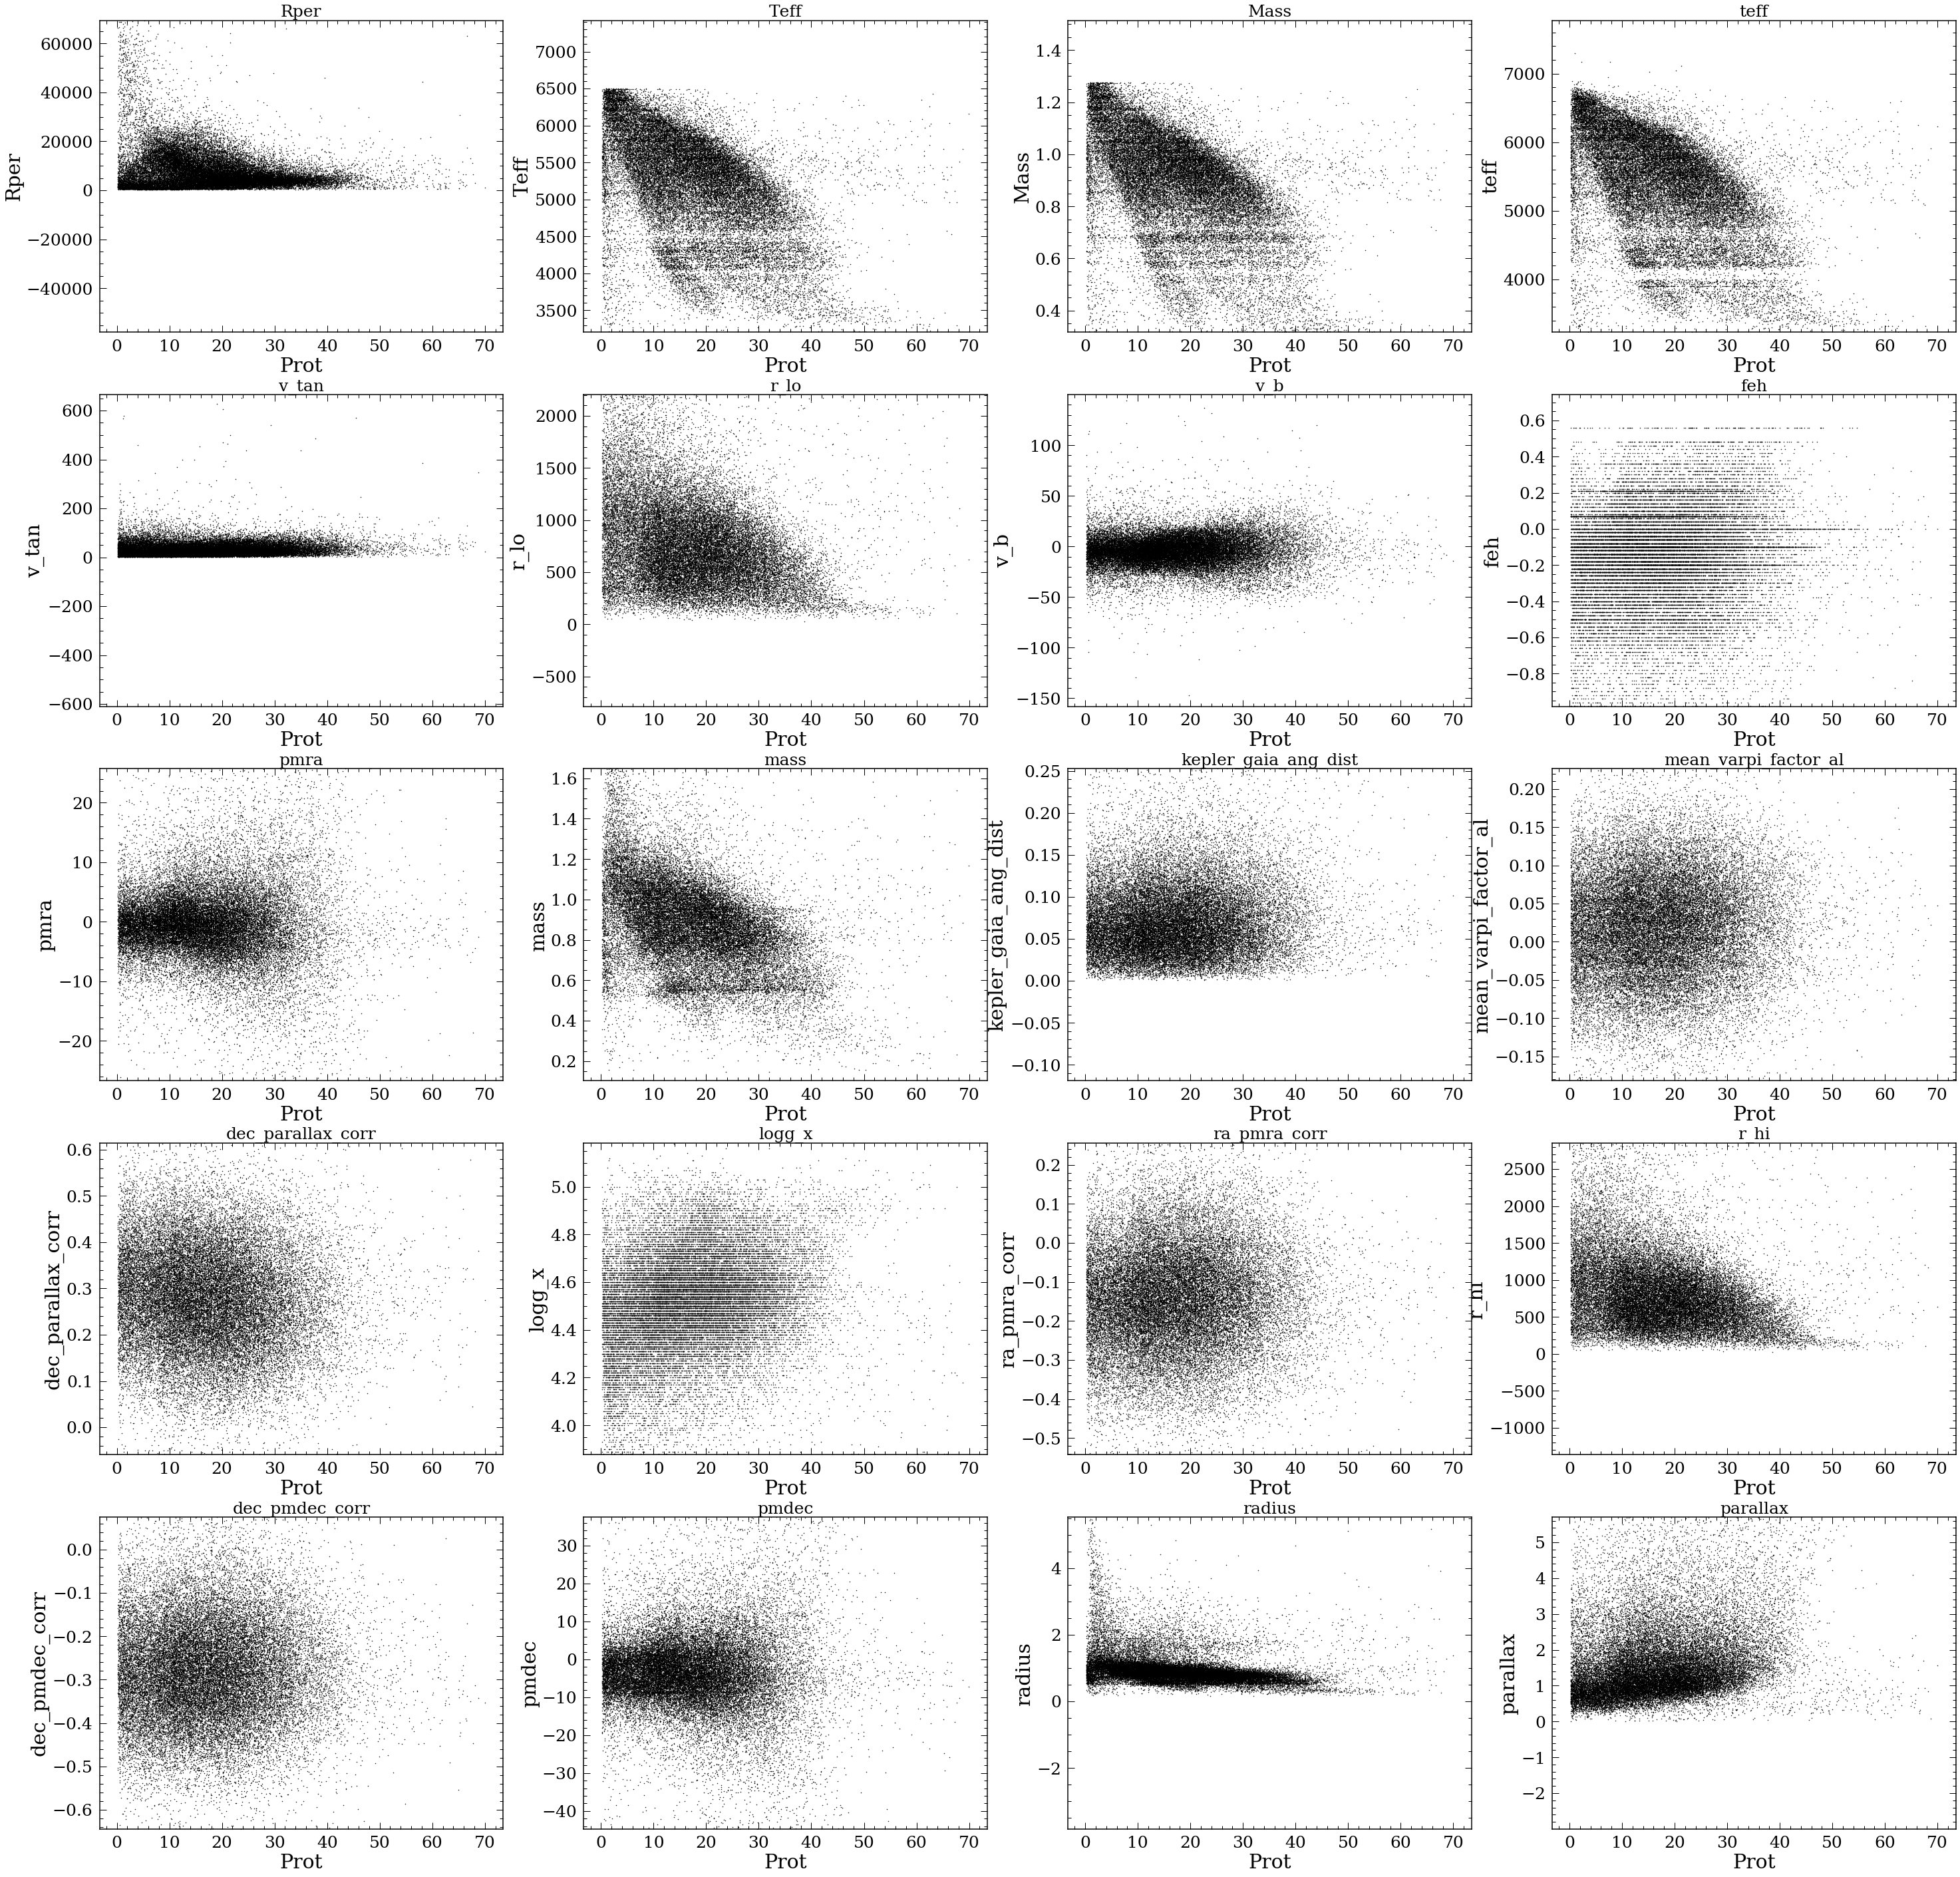

In [255]:
plot_corr(df,x_ticks_w)

# Random stuff...

2 different masses?

In [222]:
print(df.mass)
print(df.Mass)

0        0.604
1        0.640
2        0.690
3        0.506
4        0.631
         ...  
34885    0.825
34886    0.741
34887    0.924
34888    0.887
34889    0.771
Name: mass, Length: 32188, dtype: float64
0        0.4699
1        0.6472
2        0.5914
3        0.4497
4        0.5606
          ...  
34885    0.9798
34886    0.7591
34887    0.9062
34888    0.9227
34889    0.8239
Name: Mass, Length: 32188, dtype: float64


Get mean stdev from model

## Test with only a couple of features...

In [223]:
def my_randF_LF(df,traind,ignf_2=[]):
    # inputs
    # other features: R35, R1s? 
    # df: the data
    # traind: what fraction of data use to train
    # ignf_2: what features to use
    
    # outputs:
    # flib: lib for features indexed
    # regr: trained model
    # importance: importance of features
    # actrualF: actrual feature used
    # predictp: predicted periods
    
    # number the features with dictionary
    fl=len(df.columns) # how many features
    keys=range(fl)
    flib=dict(zip(keys, df.columns))

    featl=len(df.Prot) # feature length

    # initalize feature array
    X=np.zeros([featl,fl])

    actrualF=[] # actrual feature used
    # fill in feature array
    for i in range(1,fl):
        feature=df.iloc[:,i]
        # if input feature is in ignf_2
        if (flib[i] in ignf_2):
            X[:,i]=feature
            actrualF.append(flib[i])
    
    # output
    y=np.array(df.Prot)

    # run random forest
    regr = RandomForestRegressor(random_state=0,n_estimators=100)
    regr.fit(X[0:int(traind*featl),:], y[0:int(traind*featl)])  

    # get the importance of each feature
    importance=regr.feature_importances_
    
    # make prediction
    predictp=np.zeros([len(range(int(traind*featl)+1,featl)),1]) # predicted period
    difc=0
    for i in range(int(traind*featl)+1,featl):
        predictp[difc]=regr.predict([X[i,:]])
        difc=difc+1
    
    return flib,regr,importance,actrualF,predictp,X

traind=0.7
#features used
feat=['v_b','v_tan','Rper','logg_x','radius','mass']
#df_2=df[df.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)] # replace all inf with nan
df_2=df.dropna(subset=feat) # drop any nana in feature rows
df_2=df_2.reset_index(drop=True) # reset index
print(df_2)

flib_f,regr_f,importance_f,actrualF_f,predict_f,X_f=my_randF_LF(df_2,traind,feat)

            KID  Teff  logg_x    Mass    Prot  Prot_err      Rper    LPH  \
0        892376  3813    4.47  0.4699   1.532     0.007   7306.69  0.823   
1       1026146  4261    4.57  0.6472  14.891     0.120  11742.56  1.405   
2       1026474  4122    4.56  0.5914   1.569     0.006  30471.80  1.204   
3       1162635  3760    4.77  0.4497  15.678     0.019  10207.47  0.978   
4       1164102  4045    4.62  0.5606  31.496     0.474   5139.74  0.568   
...         ...   ...     ...     ...     ...       ...       ...    ...   
32183  12934451  5556    4.46  0.9798  17.244     0.567   2147.85  0.435   
32184  12934465  4714    4.88  0.7591  34.910     1.692   4572.33  0.433   
32185  12934525  5278    4.72  0.9062  25.101     0.240   5150.14  0.573   
32186  12934557  5341    4.58  0.9227  31.226     0.729   1889.88  0.401   
32187  12984138  4960    4.57  0.8239  12.059     0.038  11734.90  1.194   

            w  DC  ... nconfp  nkoi ntce    jmag    hmag    kmag  planet?  \
0      0.4

In [224]:
print(df.columns)
print(importance_f)

Index(['KID', 'Teff', 'logg_x', 'Mass', 'Prot', 'Prot_err', 'Rper', 'LPH', 'w',
       'DC',
       ...
       'nconfp', 'nkoi', 'ntce', 'jmag', 'hmag', 'kmag', 'planet?',
       'kepler_gaia_ang_dist', 'v_b', 'v_tan'],
      dtype='object', length=147)
[0.         0.         0.07257908 0.         0.         0.
 0.27928688 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

average chisq is:  [2134.70896008]


TypeError: object of type 'int' has no len()

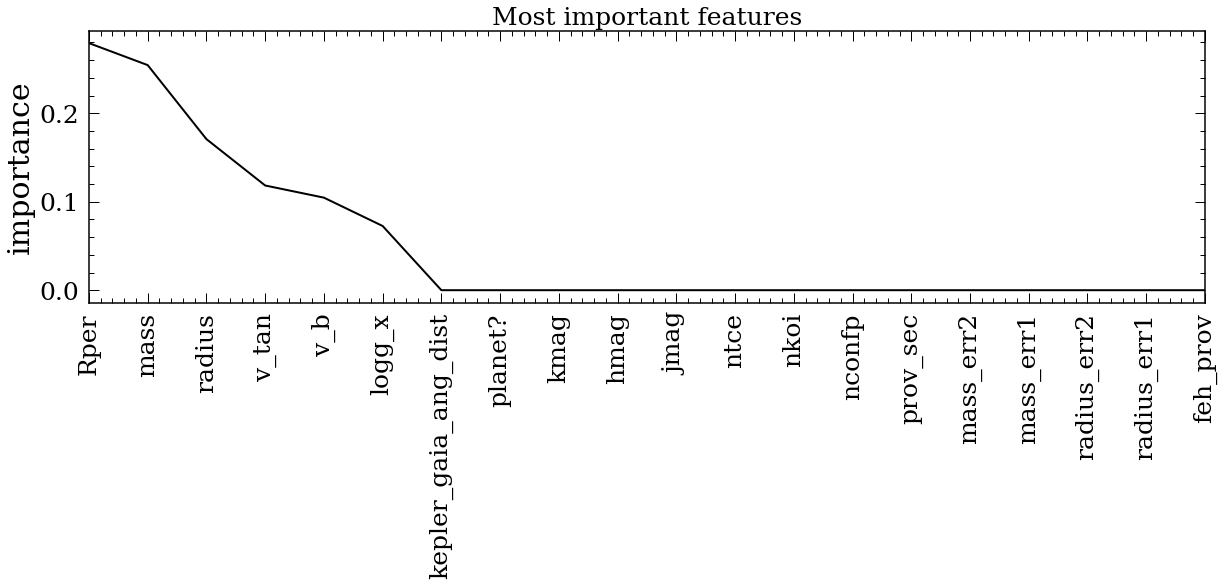

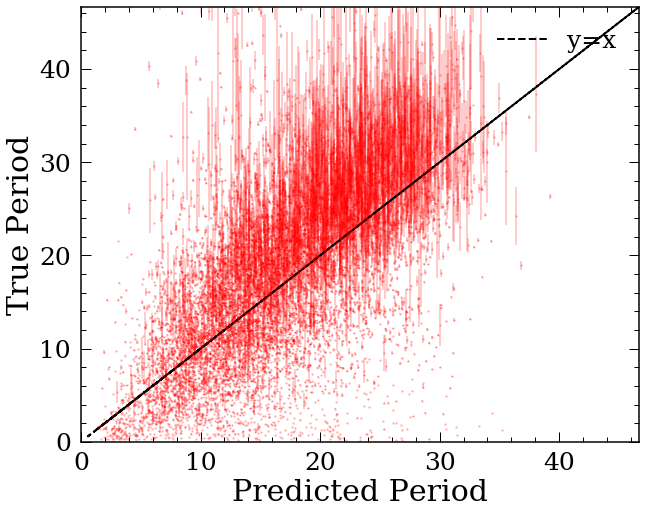

In [225]:
plot_result(df.columns,importance_f,predict_f,df_2.Prot,df_2.Prot_err,traind,len(actrualF_f))